# autoreload notebook magic

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Imports

In [4]:
'''
Train respeller model

We backpropagate loss from pretrained TTS model to a Grapheme-to-Grapheme (G2G) respeller model to help it respell words
into a simpler form

Intermediated respellings are discrete character sequences
We can backpropagate through these using gumbel softmax and the straight through estimator
'''
import argparse
import numpy as np
import torch
import torch.distributed as dist
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import glob
import re
from collections import defaultdict

from fastpitch import models as fastpitch_model
from fastpitch.common.text.text_processing import TextProcessor

from modules.model import EncoderRespeller
from modules.gumbel_vector_quantizer import GumbelVectorQuantizer
from modules.sdtw_cuda_loss import SoftDTW

import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

import fastpitch.common.tb_dllogger as logger
from torch_optimizer import Lamb
import time
from fastpitch.common.utils import mask_from_lens
from collections import OrderedDict

import os
from collections import Counter
from tqdm import tqdm

/home/s1785140/miniconda3/envs/fastpitch/lib/python3.8/site-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# simulate running script at command line with arguments

## set experiment name

In [5]:
gamma = 0.1
lr = 0.1 # def for lamb optimizer is 0.001
dist_metric = 'l1'

wandb_project_name = "respeller-training"
exp_name = f"test_trainpy_script-gamma={gamma}-lr={lr}-dist-func={dist_metric}"
fastpitch_chkpt = 'fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_checkpoint_1000.pt' # 'fastpitch/exps/halved_ljspeech_data/FastPitch_checkpoint_1000.pt',

## CLAs that affect training loop in this notebook!!!

In [6]:
# imitate CLAs
import sys
sys.argv = [
    'train.py',
    '--wandb-project-name', wandb_project_name,
    '--chkpt-save-dir', f'/home/s1785140/respeller/exps/{exp_name}', 
    '--fastpitch-chkpt', fastpitch_chkpt,
    '--input-type', 'char',
    '--symbol-set', 'english_basic_lowercase_no_arpabet',
    '--use-mas',
    '--cuda',
    '--n-speakers', '1',
    '--use-sepconv',
    # '--add-spaces',
    # '--eos-symbol', '$',
    '--batch-size', '1',
    '--val-num-to-gen', '2',
    '--softdtw-temp', str(gamma),
    '--dist-func', dist_metric,
    '--learning-rate', str(lr),
    
    # NB for real training!
    # '--epochs', '10000', 
    # '--val-log-interval', '10',
    # '--resume', # resume from latest checkpoint
    
    # # NB for development!
    '--epochs', '2', # NB for development!
    '--val-log-interval', '1', # NB for development!
    '--max-iters-per-epoch', '5', # NB for development!
    # '--skip-before-train-loop-validation', # NB for development!
]

In [7]:
# print the command to be run so we can copy and paste it into terminal if needs be
print(f"python", " ".join(sys.argv))

python train.py --wandb-project-name respeller-training --chkpt-save-dir /home/s1785140/respeller/exps/test_trainpy_script-gamma=0.1-lr=0.1-dist-func=l1 --fastpitch-chkpt fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_checkpoint_1000.pt --input-type char --symbol-set english_basic_lowercase_no_arpabet --use-mas --cuda --n-speakers 1 --use-sepconv --batch-size 1 --val-num-to-gen 2 --softdtw-temp 0.1 --dist-func l1 --learning-rate 0.1 --epochs 2 --val-log-interval 1 --max-iters-per-epoch 5


In [8]:
def prettyprint_cla_for_training(sys_argv):
    """for every flag and its arguments print on a new line"""
    def print_line(to_print, skip_eol_backslash=False):
        s = "    " + " ".join(to_print)
        if i != len(args) - 1:
            s += " \\"
        print(s)
    
    to_print = []
    args = sys_argv[1:]
    for i, arg in enumerate(args):            
        if arg.startswith('--') and i != 0:
            print_line(to_print)
            to_print = []
        to_print.append(arg)
        
    print_line(to_print, skip_eol_backslash=True)
            
print("cd /home/s1785140/respeller")
print("python train.py \\")
prettyprint_cla_for_training(sys.argv)

cd /home/s1785140/respeller
python train.py \
    --wandb-project-name respeller-training \
    --chkpt-save-dir /home/s1785140/respeller/exps/test_trainpy_script-gamma=0.1-lr=0.1-dist-func=l1 \
    --fastpitch-chkpt fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_checkpoint_1000.pt \
    --input-type char \
    --symbol-set english_basic_lowercase_no_arpabet \
    --use-mas \
    --cuda \
    --n-speakers 1 \
    --use-sepconv \
    --batch-size 1 \
    --val-num-to-gen 2 \
    --softdtw-temp 0.1 \
    --dist-func l1 \
    --learning-rate 0.1 \
    --epochs 2 \
    --val-log-interval 1 \
    --max-iters-per-epoch 5


# print sbatch.sh hyperparam sweep training commands

In [17]:
import itertools

def train_commands_for_hparam_sweep(
    wandb_project_name,
    tts_model_path,
    gammas,
    lrs,
    arch_cfgs,
):
    for gamma, lr in itertools.product(*[gammas, lrs]):
        for arch in arch_cfgs:
            exp_name = f"bsz1-nospaces-gamma={gamma}-lr={lr}-nheads={arch['nheads']}-nlayers={arch['num_layers']}-ffdim={arch['d_model']}-freeze"
            sys_argv = [
                'train.py',
                '--wandb-project-name', wandb_project_name,
                '--chkpt-save-dir', f'/home/s1785140/respeller/exps/{exp_name}', 
                # '--fastpitch-chkpt', 'fastpitch/exps/halved_ljspeech_data/FastPitch_checkpoint_1000.pt', 
                '--fastpitch-chkpt', tts_model_path,
                '--input-type', 'char',
                '--symbol-set', 'english_basic_lowercase_no_arpabet',
                '--use-mas',
                '--cuda',
                '--n-speakers', '1',
                '--use-sepconv',
                '--nheads', str(arch['nheads']),
                '--num-layers', str(arch['num_layers']),
                '--d-model', str(arch['d_model']),
                '--freeze-embedding-table', 'True',
                # '--add-spaces',
                # '--eos-symbol', '$',
                '--batch-size', '1',
                '--val-num-to-gen', '16',
                '--softdtw-temp', str(gamma),
                '--dist-func', "l1",
                '--learning-rate', str(lr),
                # NB for real training!
                '--epochs', '1000', 
                '--val-log-interval', '5',
                # '--resume', # resume from latest checkpoint

            ]
            print("./sbatch.sh python train.py \\")
            prettyprint_cla_for_training(sys_argv)
            print("\n")
        
# train_commands_for_hparam_sweep(gammas=[1.0], lrs=[1.0, 0.1]) # test

print("cd /home/s1785140/respeller")
train_commands_for_hparam_sweep(
    wandb_project_name='respeller',
    tts_model_path=fastpitch_chkpt,
    gammas=[1.0], 
    #gammas=[1.0, 0.1, 0.01], 
    lrs=[10.0],
    #lrs=[0.1, 0.01, 0.001],
    arch_cfgs=[
        {'nheads': 4, 'num_layers': 4, 'd_model':512},
        {'nheads': 2, 'num_layers': 2, 'd_model':256},
        {'nheads': 1, 'num_layers': 1, 'd_model':128},
    ],
)


cd /home/s1785140/respeller
./sbatch.sh python train.py \
    --wandb-project-name respeller \
    --chkpt-save-dir /home/s1785140/respeller/exps/bsz1-nospaces-gamma=1.0-lr=10.0-nheads=4-nlayers=4-ffdim=512-freeze \
    --fastpitch-chkpt fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_checkpoint_1000.pt \
    --input-type char \
    --symbol-set english_basic_lowercase_no_arpabet \
    --use-mas \
    --cuda \
    --n-speakers 1 \
    --use-sepconv \
    --nheads 4 \
    --num-layers 4 \
    --d-model 512 \
    --freeze-embedding-table True \
    --batch-size 1 \
    --val-num-to-gen 16 \
    --softdtw-temp 1.0 \
    --dist-func l1 \
    --learning-rate 10.0 \
    --epochs 1000 \
    --val-log-interval 5


./sbatch.sh python train.py \
    --wandb-project-name respeller \
    --chkpt-save-dir /home/s1785140/respeller/exps/bsz1-nospaces-gamma=1.0-lr=10.0-nheads=2-nlayers=2-ffdim=256-freeze \
    --fastpitch-chkpt fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_

# dev train loop + model for respeller

# Functions

## arguments to parse

In [132]:
def parse_args(parser):
    """Parse commandline arguments"""
    parser.add_argument('--wandb-project-name', type=str, required=True,
                        help='Which wandb project to add this job to')
    parser.add_argument('-o', '--chkpt-save-dir', type=str, required=True,
                        help='Directory to save checkpoints')
    parser.add_argument('-d', '--dataset-path', type=str, default='./',
                        help='Path to dataset')
    parser.add_argument('--log-file', type=str, default=None,
                        help='Path to a DLLogger log file')

    train = parser.add_argument_group('training setup')
    train.add_argument('--cuda', action='store_true',
                      help='Enable GPU training')
    train.add_argument('--batch-size', type=int, default=16,
                      help='Batchsize (this is divided by number of GPUs if running Data Distributed Parallel Training)')
    train.add_argument('--val-num-to-gen', type=int, default=32,
                      help='Number of samples to generate in validation (determines how many samples show up in wandb')
    train.add_argument('--seed', type=int, default=1337,
                       help='Seed for PyTorch random number generators')
    train.add_argument('--grad-accumulation', type=int, default=1,
                       help='Training steps to accumulate gradients for')
    train.add_argument('--epochs', type=int, default=100, #required=True,
                       help='Number of total epochs to run')
    train.add_argument('--max-iters-per-epoch', type=int, default=None, 
                       help='Number of total batches to iterate through each epoch (reduce this to small number to quickly test whole training loop)')
    train.add_argument('--epochs-per-checkpoint', type=int, default=10,
                       help='Number of epochs per checkpoint')
    train.add_argument('--checkpoint-path', type=str, default=None,
                       help='Checkpoint path to resume train')
    train.add_argument('--resume', action='store_true',
                       help='Resume train from the last available checkpoint')
    train.add_argument('--val-log-interval', type=int, default=5,
                       help='How often to generate melspecs/audio for respellings and log to wandb')
    train.add_argument('--speech-length-penalty-training', action='store_true',
                       help='Whether or not to encourage model to output similar length outputs\
                       as the ground truth. Idea from V2C: Visual Voice Cloning (Chen et al. 2021)')
    train.add_argument('--skip-before-train-loop-validation', action='store_true',
                       help='Skip running validation before model training begins (mostly for speeding up testing of actual training loop)')
    train.add_argument('--avg-loss-by-speech_lens', action='store_true',
                       help='Average the softdtw loss according to number of timesteps in predicted sequence')
    train.add_argument('--softdtw-temp', type=float, default=0.01,
                      help='How hard/soft to make min operation. Minimum is recovered by setting this to 0.')
    train.add_argument('--softdtw-bandwidth', type=int, default=120,
                      help='Bandwidth for pruning paths in alignment matrix when calculating SoftDTW')
    train.add_argument('--dist-func', type=str, default="l1",
                       help='What distance function to use in softdtw loss calculation')
    
    opt = parser.add_argument_group('optimization setup')
    opt.add_argument('--optimizer', type=str, default='lamb', choices=['adam', 'lamb'],
                     help='Optimization algorithm')
    opt.add_argument('-lr', '--learning-rate', default=0.1, type=float,
                     help='Learning rate')
    opt.add_argument('--weight-decay', default=1e-6, type=float,
                     help='Weight decay')
    opt.add_argument('--grad-clip-thresh', default=1000.0, type=float,
                     help='Clip threshold for gradients')
    opt.add_argument('--warmup-steps', type=int, default=1000,
                     help='Number of steps for lr warmup')

    arch = parser.add_argument_group('architecture')
    arch.add_argument('--d-model', type=int, default=512,
                       help='Hidden dimension of tranformer')
    arch.add_argument('--latent-temp', type=tuple, default=(2, 0.5, 0.999995),
                       help='Temperature annealling parameters for Gumbel-Softmax (start, end, decay)')

    pretrained_tts = parser.add_argument_group('pretrained tts model')
    # pretrained_tts.add_argument('--fastpitch-with-mas', type=bool, default=True,
    #                   help='Whether or not fastpitch was trained with Monotonic Alignment Search (MAS)')
    pretrained_tts.add_argument('--fastpitch-chkpt', type=str, required=True,
                      help='Path to pretrained fastpitch checkpoint')
    pretrained_tts.add_argument('--input-type', type=str, default='char',
                      choices=['char', 'phone', 'pf', 'unit'],
                      help='Input symbols used, either char (text), phone, pf '
                      '(phonological feature vectors) or unit (quantized acoustic '
                      'representation IDs)')
    pretrained_tts.add_argument('--symbol-set', type=str, default='english_basic_lowercase',
                      help='Define symbol set for input sequences. For quantized '
                      'unit inputs, pass the size of the vocabulary.')
    pretrained_tts.add_argument('--n-speakers', type=int, default=1,
                      help='Condition on speaker, value > 1 enables trainable '
                      'speaker embeddings.')
    # pretrained_tts.add_argument('--use-sepconv', type=bool, default=True,
    #                   help='Use depthwise separable convolutions')
    
    audio = parser.add_argument_group('log generated audio')
    audio.add_argument('--hifigan', type=str, default='/home/s1785140/pretrained_models/hifigan/ljspeech/LJ_V1/generator_v1',
                       help='Path to HiFi-GAN audio checkpoint')
    audio.add_argument('--hifigan-config', type=str, default='/home/s1785140/pretrained_models/hifigan/ljspeech/LJ_V1/config.json',
                       help='Path to HiFi-GAN audio config file')
    audio.add_argument('--sampling-rate', type=int, default=22050,
                       help='Sampling rate for output audio')
    audio.add_argument('--hop-length', type=int, default=256,
                       help='STFT hop length for estimating audio length from mel size')
    
    data = parser.add_argument_group('dataset parameters')
    data.add_argument('--wordaligned-speechreps', type=str, default='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels',
                       help='Path to directory of wordaligned speechreps/mels. Inside are folders\
                       each named as a wordtype and containing tensors of word aligned speechreps for each example')
    data.add_argument('--train-wordlist', type=str, default='/home/s1785140/data/ljspeech_fastpitch/respeller_train_words.json',
                       help='Path to words that are used to train respeller')
    data.add_argument('--val-wordlist', type=str, default='/home/s1785140/data/ljspeech_fastpitch/respeller_dev_words.json',
                       help='Path to words that are used to report validation metrics for respeller')
    data.add_argument('--max-examples-per-wordtype', type=int, default=1,
                       help='Path to words that are used to report validation metrics for respeller')
    # data.add_argument('--add-spaces', action='store_true',
    #                   help='Whether to add leading space and trailing EOS symbol to word during training and test.')
    
    
    cond = parser.add_argument_group('conditioning on additional attributes')
    dist = parser.add_argument_group('distributed training setup')

    return parser

def load_checkpoint(args, model, filepath):
    if args.local_rank == 0:
        print(f'Loading model and optimizer state from {filepath}')
    checkpoint = torch.load(filepath, map_location='cpu')
    sd = {k.replace('module.', ''): v
          for k, v in checkpoint['state_dict'].items()}
    getattr(model, 'module', model).load_state_dict(sd)
    return model

def load_respeller_checkpoint(args, model, filepath, optimizer, epoch, total_iter):
    if args.local_rank == 0:
        print(f'Loading model and optimizer state from {filepath}')
    checkpoint = torch.load(filepath, map_location='cpu')
    epoch[0] = checkpoint['epoch'] + 1
    total_iter[0] = checkpoint['iteration']
    sd = {k.replace('module.', ''): v
          for k, v in checkpoint['state_dict'].items()}
    getattr(model, 'module', model).load_state_dict(sd)
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model

def last_checkpoint(output):
    saved = sorted(
        glob.glob(f'{output}/respeller_checkpoint_*.pt'),
        key=lambda f: int(re.search('_(\d+).pt', f).group(1)))

    def corrupted(fpath):
        try:
            torch.load(fpath, map_location='cpu')
            return False
        except:
            warnings.warn(f'Cannot load {fpath}')
            return True

    if len(saved) >= 1 and not corrupted(saved[-1]):
        return saved[-1]
    elif len(saved) >= 2:
        return saved[-2]
    else:
        return None

def init_embedding_weights(source_tensor, target_tensor):
    """copy weights inplace from source tensor to target tensor"""
    target_tensor.requires_grad = False
    target_tensor.copy_(source_tensor.clone().detach())
    target_tensor.requires_grad = True

def load_pretrained_fastpitch(args):
    # load chkpt
    device = torch.device('cuda' if args.cuda else 'cpu')
    model_config = fastpitch_model.get_model_config('FastPitch', args)
    fastpitch = fastpitch_model.get_model('FastPitch', model_config, device, forward_is_infer=True)
    load_checkpoint(args, fastpitch, args.fastpitch_chkpt)
    # get information about grapheme embedding table
    n_symbols = fastpitch.encoder.word_emb.weight.size(0)
    grapheme_embedding_dim = fastpitch.encoder.word_emb.weight.size(1)
    return fastpitch, n_symbols, grapheme_embedding_dim, model_config

# beginning of main(), parse Command Line Args

In [133]:
parser = argparse.ArgumentParser(description='PyTorch Respeller Training', allow_abbrev=False)
parser = parse_args(parser)
args, _unk_args = parser.parse_known_args()

parser = fastpitch_model.parse_model_args('FastPitch', parser)
args, unk_args = parser.parse_known_args()
if len(unk_args) > 0:
    raise ValueError(f'Invalid options {unk_args}')

if args.cuda:
    args.num_gpus = torch.cuda.device_count()
    args.distributed_run = args.num_gpus > 1
    args.batch_size = int(args.batch_size / args.num_gpus)
else:
    args.distributed_run = False

torch.manual_seed(args.seed)
np.random.seed(args.seed)

if args.distributed_run:
    mp.spawn(train, nprocs=args.num_gpus, args=(args,))

# WANDB - weights and biases init

In [134]:
import wandb
wandb.login() # needed for wandb integration with jupyter notebook

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [135]:
%env "WANDB_NOTEBOOK_NAME" "respeller-dev-train-ipynb"

env: "WANDB_NOTEBOOK_NAME"="respeller-dev-train-ipynb"


## set project name and run name

In [136]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y-%H:%M:%S")
print("date and time =", dt_string)

now = 2023-01-16 18:16:29.242653
date and time = 16/01/2023-18:16:29


In [137]:
run = 1

project_name = args.wandb_project_name #"respeller-dev-train-ipynb"
experiment_name = f"{exp_name}_run-{run}_{dt_string}"

# store important information into WANDB config for easier tracking of experiments
# add all key values from parser
wandb_config = vars(args)
wandb.init(
    project=project_name,
    name=experiment_name,
    config=wandb_config,
)

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/s1785140/miniconda3/envs/fastpitch/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/s1785140/miniconda3/envs/fastpitch/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s1785140/miniconda3/envs/fastpitch/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/home/s1785140/miniconda3/envs/fastpitch/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/disk.py", line 76, in start
    self.metrics_monitor.start()
  File "/home/s1785140/miniconda3/envs/fastpitch/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


memory/allocated,▇▇▇▇▇▇▁▁▁▁▁▁████████████
memory/free,▁▁▁▂▂▂▃▃▃▃▃▃████████████
memory/reserved,▁▁▁▂▂▂▃▃▃▃▃▃████████████
memory/total,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_loss,█▅▅▁
train/epoch_num,▁█▁█
train/epoch_time,█▁▁▂
train/iter_loss,█▅▃█▂▅█▁▆▄▅▅▄▇▂▆▅▄▃▂▅▃█▃
train/iter_sl_penalty_coef,▁▁▂▁▂▄▁▃▁▂▂▁▁█▂▅▂▂▁▂▄▄▅▂
train/iter_time,█▁▁▁▆▅▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val/epoch_loss,▇▇█▁▁▁


# 'train()' - forward pass through model to get loss

## create / load models 

In [138]:
rank = 0
device = 'cuda'

args.local_rank = rank
tts, n_symbols, grapheme_embedding_dim, model_config = load_pretrained_fastpitch(args)
tts.to(device)

respeller = EncoderRespeller(n_symbols=n_symbols, pretrained_tts=tts, d_model=args.d_model)
respeller.to(device)

# quantiser = GumbelVectorQuantizer(
#     in_dim=args.d_model,
#     codebook_size=n_symbols,  # number of codebook entries
#     embedding_dim=grapheme_embedding_dim,
#     temp=args.latent_temp,
# )
# quantiser.to(device)

# init_embedding_weights(tts.encoder.word_emb.weight.unsqueeze(0), quantiser.vars)


# batch_size, len_x, len_y, dims = 8, 15, 12, 5
# x = torch.rand((batch_size, len_x, dims), requires_grad=True)
# y = torch.rand((batch_size, len_y, dims))

# criterion = SoftDTW(use_cuda=True, gamma=0.1, dist_func=F.mse_loss)
criterion = SoftDTW(use_cuda=True, gamma=args.softdtw_temp)
# input should be size [bsz, seqlen, dim]
criterion.to(device)

Loading model and optimizer state from fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_checkpoint_960.pt


SoftDTW()

### load HiFiGAN vocoder 

In [139]:
def load_vocoder(args, device):
    """Load HiFi-GAN vocoder from checkpoint"""
    checkpoint_data = torch.load(args.hifigan)
    vocoder_config = fastpitch_model.get_model_config('HiFi-GAN', args)
    vocoder = fastpitch_model.get_model('HiFi-GAN', vocoder_config, device)
    vocoder.load_state_dict(checkpoint_data['generator'])
    vocoder.remove_weight_norm()
    vocoder.eval()
    return vocoder

In [140]:
vocoder = load_vocoder(args, device)

## forward pass through model with dummy data

In [141]:
batches = []
symbol_set = 'english_basic_lowercase'
text_cleaners = []
gt_log_mel = torch.load('/home/s1785140/data/ljspeech_fastpitch/mels/LJ001-0001.pt').cuda().unsqueeze(0).transpose(1,2) # intro batch dimension + [bsz, seqlen, dim]
raw_text = 'printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the exhibition'

# process text using same processor as fastpitch
tp = TextProcessor(symbol_set, text_cleaners)
text = torch.LongTensor(tp.encode_text(raw_text)).unsqueeze(0).cuda()

batches.append((text, gt_log_mel))

In [142]:
text.size()

torch.Size([1, 151])

In [143]:
text.device

device(type='cuda', index=0)

In [144]:
# for batch in batches:
batch = batches[0]
    
###############################################################################################################
# text, ssl_reps, e2e_asr_predictions, gt_log_mel = batch
text, gt_log_mel = batch

###############################################################################################################
# create inputs
# if args.use_acoustic_input:
#     inputs = inputs.concat(ssl_reps)

###############################################################################################################
# forward pass
g_embeddings, g_embedding_indices = respeller(text[:13])

In [145]:
n_symbols

40

In [146]:
g_embedding_indices.size()

torch.Size([1, 151])

In [147]:
g_embeddings.size()

torch.Size([1, 151, 384])

In [148]:
padding_idx = 0
mask = (g_embedding_indices != padding_idx).unsqueeze(2)
mask.size()

torch.Size([1, 151, 1])

In [149]:
log_mel, dec_lens, _dur_pred, _pitch_pred = tts(g_embeddings, skip_embeddings=True, ids=g_embedding_indices)
# log_mel [bsz, dim, seqlen]
log_mel = log_mel.transpose(1,2)
# log_mel [bsz, seqlen, dim]

print(f'{log_mel.size()=}')
print(f'{gt_log_mel.size()=}')

###############################################################################################################
# calculate val_losses
# respelling_loss = respelling_loss_fn(respelling, e2e_asr_predictions)
acoustic_loss = criterion(log_mel, gt_log_mel)

# average loss over frames 
acoustic_loss = acoustic_loss / dec_lens
# mel_loss = (mel_loss * mel_mask).sum() / mel_mask.sum()

###############################################################################################################
# backward pass
loss = acoustic_loss 

print(f'{loss=}')

# loss.backward()

###############################################################################################################
# log tensorboard metrics

###############################################################################################################
# validation set evaluation

log_mel.size()=torch.Size([1, 865, 80])
gt_log_mel.size()=torch.Size([1, 832, 80])
loss=tensor([244.7880], device='cuda:0', grad_fn=<DivBackward0>)


In [150]:
def plot_spectrogram(log_mel, figsize=(15,5), wandb_log=False, image_name=""):
    plt.figure(figsize=figsize)
    librosa.display.specshow(log_mel, x_axis='frames', y_axis='linear')
    plt.colorbar()
    if wandb_log:
        wandb.log({image_name: wandb.Image(plt, caption=image_name)})

log_mel[batch_index].transpose(0,1).size()=torch.Size([80, 865])


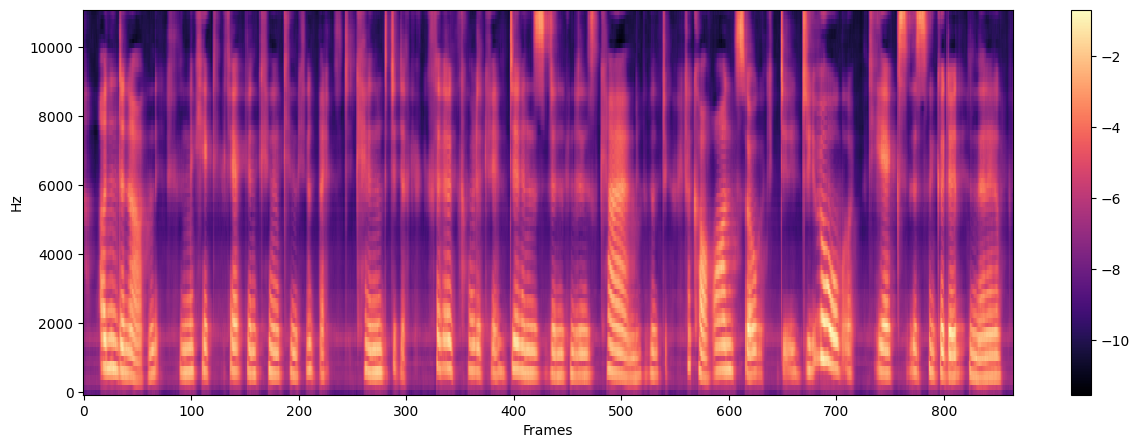

In [151]:
batch_index = 0
print(f'{log_mel[batch_index].transpose(0,1).size()=}')
plot_spectrogram(log_mel[batch_index].transpose(0,1).detach().cpu().numpy())

In [152]:
# # play audio
# import IPython.display as ipd
# audio = vocoder(log_mel[batch_index].transpose(0,1).detach().unsqueeze(0))
# ipd.Audio(audio, rate=22050)

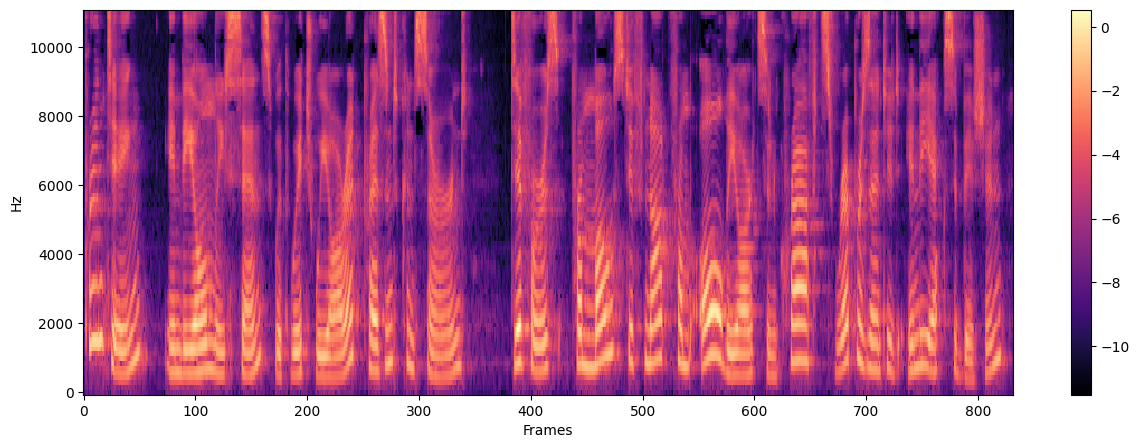

In [153]:
batch_index = 0
plot_spectrogram(gt_log_mel[batch_index].transpose(0,1).detach().cpu().numpy())

# develop respeller dataset

In [154]:
wordaligned_speechreps_dir = '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels' # path to directory that contains folders of word aligned speech reps
wordlist = ['identifies','mash','player','russias','techniques'] # txt file for the words to include speech reps 

In [155]:
token_and_melfilepaths = []
for word in wordlist:
    # find all word aligned mels for the word
    word_dir = os.path.join(wordaligned_speechreps_dir, word)
    mel_files = os.listdir(word_dir)
    for mel_file in mel_files:
        mel_file_path = os.path.join(word_dir, mel_file)
        token_and_melfilepaths.append((word, mel_file_path))
    

In [156]:
token_and_melfilepaths

[('identifies',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/identifies/identifies__LJ040-0003__occ1__seqlen68.pt'),
 ('mash',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/mash/mash__LJ020-0011__occ1__seqlen28.pt'),
 ('player',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/player/player__LJ041-0014__occ1__seqlen49.pt'),
 ('russias',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/russias/russias__LJ042-0204__occ1__seqlen38.pt'),
 ('techniques',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/techniques/techniques__LJ046-0157__occ1__seqlen73.pt'),
 ('techniques',
  '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels/techniques/techniques__LJ050-0196__occ1__seqlen59.pt')]

## process text

In [157]:
from fastpitch.common.text.text_processing import TextProcessor
text_cleaners = []
symbol_set = "english_basic_lowercase_no_arpabet"
tp = TextProcessor(symbol_set, text_cleaners, add_spaces=True, eos_symbol="$")

In [158]:
encoded = torch.IntTensor(tp.encode_text('identifies'))
encoded

tensor([12, 21, 16, 17, 26, 32, 21, 18, 21, 17, 31, 39], dtype=torch.int32)

In [161]:
decoded = [tp.id_to_symbol[id] for id in encoded.tolist()]
decoded

[' ', 'i', 'd', 'e', 'n', 't', 'i', 'f', 'i', 'e', 's', '$']

## process mel

In [162]:
word, fp = token_and_melfilepaths[0]
wordaligned_mel = torch.load(fp)
wordaligned_mel.size() # [seqlen, feats]

torch.Size([68, 80])

## 'class'-ified dataset class

In [163]:
from fastpitch.common.text.text_processing import TextProcessor

class RespellerDataset(torch.utils.data.Dataset):
    """
        1) loads word + word-aligned mel spec for all words in a wordlist
        2) converts text to sequences of one-hot vectors (corresponding to grapheme indices in fastpitch)
    """
    def __init__(
        self, 
        wordaligned_speechreps_dir, # path to directory that contains folders of word aligned speech reps
        wordlist, # txt file for the words to include speech reps from
        max_examples_per_wordtype=None,
        text_cleaners=[],
        symbol_set="english_basic_lowercase_no_arpabet",
        add_spaces=True,
        eos_symbol="$",
        **kwargs,
    ):
        # load wordlist as a python list
        if type(wordlist) == str:
            if wordlist.endswith('.json'):
                with open(wordlist) as f:
                    wordlist = json.load(f)
            else:
                with open(wordlist) as f:
                    wordlist = f.read().splitlines()
        elif type(wordlist) == list:
            pass # dont need to do anything, already in expected form
        elif type(wordlist) == set:
            wordlist = list(wordlist)
        
        wordlist = sorted(wordlist)
        
        # create list of all word tokens and their word aligned speech reps
        self.word_freq = Counter()
        self.token_and_melfilepaths = []
        print("Initialising respeller dataset")
        for word in tqdm(wordlist):
            # find all word aligned mels for the word
            word_dir = os.path.join(wordaligned_speechreps_dir, word)
            mel_files = os.listdir(word_dir)
            if max_examples_per_wordtype:
                mel_files = mel_files[:max_examples_per_wordtype]
            for mel_file in mel_files:
                mel_file_path = os.path.join(word_dir, mel_file)
                self.token_and_melfilepaths.append((word, mel_file_path))
                self.word_freq[word] += 1
                
        self.tp = TextProcessor(symbol_set, text_cleaners, add_spaces=add_spaces, eos_symbol=eos_symbol)

    def get_mel(self, filename):
        return torch.load(filename)

    def encode_text(self, text):
        """encode raw text into indices defined by grapheme embedding table of the TTS model"""
        return torch.IntTensor(self.tp.encode_text(text))
    
    def decode_text(self, encoded):
        return [self.tp.id_to_symbol[id] for id in encoded.tolist()]
    
    @staticmethod
    def get_mel_len(melfilepath):
        return int(melfilepath.split('seqlen')[1].split('.pt')[0])

    def __getitem__(self, index):
        word, mel_filepath = self.token_and_melfilepaths[index]
        encoded_word = self.encode_text(word)
        mel = self.get_mel(mel_filepath)
        
        return {
            'word': word, 
            'encoded_word': encoded_word, 
            'mel_filepath': mel_filepath,
            'mel': mel,
        }

    def __len__(self):
        return len(self.token_and_melfilepaths)

In [164]:
dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist=['identifies','mash','player','russias','techniques'],
)

Initialising respeller dataset


100%|███████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3009.26it/s]


In [165]:
batch = []

for itemdict in dataset:
    # unpack dict
    word = itemdict['word'] 
    encoded_word = itemdict['encoded_word'] 
    mel = itemdict['mel'] 
    
    # check
    print(word, encoded_word, mel.size())
    
    batch.append(itemdict)

identifies tensor([12, 21, 16, 17, 26, 32, 21, 18, 21, 17, 31, 39], dtype=torch.int32) torch.Size([68, 80])
mash tensor([12, 25, 13, 31, 20, 39], dtype=torch.int32) torch.Size([28, 80])
player tensor([12, 28, 24, 13, 37, 17, 30, 39], dtype=torch.int32) torch.Size([49, 80])
russias tensor([12, 30, 33, 31, 31, 21, 13, 31, 39], dtype=torch.int32) torch.Size([38, 80])
techniques tensor([12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39], dtype=torch.int32) torch.Size([73, 80])
techniques tensor([12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39], dtype=torch.int32) torch.Size([59, 80])


## collate function

In [166]:
class Collate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    # def __init__(self):
    
    def __call__(self, batch):
        """Collate's training batch from encoded word token and its 
        corresponding word-aligned mel spectrogram
        
        batch: [encoded_token, wordaligned_mel]
        """
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x['encoded_word']) for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]

        words = []
        mel_filepaths = []
        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        text_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            words.append(batch[ids_sorted_decreasing[i]]['word'])
            mel_filepaths.append(batch[ids_sorted_decreasing[i]]['mel_filepath'])
            text = batch[ids_sorted_decreasing[i]]['encoded_word']
            text_padded[i, :text.size(0)] = text
            text_lengths[i] = text.size(0)

        # Right zero-pad mel-spec
        num_mels = batch[0]['mel'].size(1)
        max_target_len = max([x['mel'].size(0) for x in batch])

        mel_padded = torch.FloatTensor(len(batch), max_target_len, num_mels)
        mel_padded.zero_()
        mel_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]]['mel']
            mel_padded[i, :mel.size(0), :] = mel
            mel_lengths[i] = mel.size(0)
            

        return {
            'words': words,
            'text_padded': text_padded,
            'text_lengths': text_lengths,
            'mel_padded': mel_padded, 
            'mel_lengths': mel_lengths,
            'mel_filepaths': mel_filepaths
        }
                # input_lengths, mel_padded, output_lengths,
                # len_x, dur_padded, dur_lens, pitch_padded, speaker)

In [167]:
collate_fn = Collate()
collated = collate_fn(batch)

In [168]:
collated['text_padded'].size()

torch.Size([6, 12])

In [169]:
collated['text_padded']

tensor([[12, 21, 16, 17, 26, 32, 21, 18, 21, 17, 31, 39],
        [12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39],
        [12, 32, 17, 15, 20, 26, 21, 29, 33, 17, 31, 39],
        [12, 30, 33, 31, 31, 21, 13, 31, 39,  0,  0,  0],
        [12, 28, 24, 13, 37, 17, 30, 39,  0,  0,  0,  0],
        [12, 25, 13, 31, 20, 39,  0,  0,  0,  0,  0,  0]])

In [170]:
collated['words']

['identifies', 'techniques', 'techniques', 'russias', 'player', 'mash']

In [171]:
collated['mel_padded'].size()

torch.Size([6, 73, 80])

## put batch on gpu

In [172]:
def to_gpu(x):
    x = x.contiguous()
    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def batch_to_gpu(collated_batch):
    """put elements that are used throughout training onto gpu"""
    words = collated_batch['words']
    text_padded = collated_batch['text_padded']
    text_lengths = collated_batch['text_lengths']
    mel_padded = collated_batch['mel_padded']
    mel_lengths = collated_batch['mel_lengths']
    
    # no need to put words on gpu, its only used during eval loop
    text_padded = to_gpu(text_padded).long()
    text_lengths = to_gpu(text_lengths).long()
    mel_padded = to_gpu(mel_padded).float()
    mel_lengths = to_gpu(mel_lengths).long()
    
    # x: inputs
    x = {
        'words': words,
        'text_padded': text_padded,
        'text_lengths': text_lengths,
    }
    # y: targets
    y = {
        'mel_padded': mel_padded, 
        'mel_lengths': mel_lengths,
    }
    
    return (x, y)

In [173]:
# batch_to_gpu(collated)

# full train + dev datasets

In [174]:
train_dataset = RespellerDataset(
    wordaligned_speechreps_dir=args.wordaligned_speechreps, # path to directory that contains folders of word aligned speech reps
    wordlist=args.train_wordlist,
    max_examples_per_wordtype=args.max_examples_per_wordtype,
    add_spaces=args.add_spaces,
)

Initialising respeller dataset


100%|█████████████████████████████████████████████████████████████| 7479/7479 [00:02<00:00, 3578.91it/s]


In [175]:
len(train_dataset)

7479

In [176]:
sum(train_dataset.word_freq.values())

7479

In [177]:
val_dataset = RespellerDataset(
    wordaligned_speechreps_dir=args.wordaligned_speechreps, # path to directory that contains folders of word aligned speech reps
    wordlist=args.val_wordlist,
    add_spaces=args.add_spaces,
)

Initialising respeller dataset


100%|███████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 3422.51it/s]


In [178]:
len(val_dataset)

415

In [179]:
sum(val_dataset.word_freq.values())

415

# create torch dataloader

In [180]:
# TODO, implement distributed training?
train_sampler = None
shuffle = True
num_cpus = 1 
train_loader = DataLoader(train_dataset, num_workers=2*num_cpus, shuffle=shuffle,
                          sampler=train_sampler, batch_size=args.batch_size,
                          pin_memory=False, drop_last=True,
                          collate_fn=collate_fn)

In [181]:
# for batch in train_loader:
#     print(batch)

# FULL train() loop

## init dl logger

In [182]:
def touch_file(path):
    if not os.path.exists(path):
        basedir = os.path.dirname(path)
        os.makedirs(basedir, exist_ok=True)
        with open(path, 'w') as f:
            f.write("")

# initialise logger
tb_subsets = ['train', 'val']
log_fpath = args.log_file or os.path.join(args.chkpt_save_dir, 'nvlog.json')
touch_file(log_fpath)

try: 
    logger.init(log_fpath, args.chkpt_save_dir, enabled=(args.local_rank == 0),
                tb_subsets=tb_subsets)
    logger.parameters(vars(args), tb_subset='train')
except:
    print("WARNING DLLLoggerAlreadyInitialized error raised")

WARNING DLLLoggerAlreadyInitialized error raised


## functions

In [183]:
def adjust_learning_rate(total_iter, opt, learning_rate, warmup_iters=None):
    if warmup_iters == 0:
        scale = 1.0
    elif total_iter > warmup_iters:
        scale = 1. / (total_iter ** 0.5)
    else:
        scale = total_iter / (warmup_iters ** 1.5)

    for param_group in opt.param_groups:
        param_group['lr'] = learning_rate * scale

def log_stdout(logger, subset, epoch_iters, total_steps, loss, took):
    logger_data = [
        ('Loss/Total', loss),
    ]
    logger_data.append(('Time/Iter time', took))
    logger.log(epoch_iters,
               tb_total_steps=total_steps,
               subset=subset,
               data=OrderedDict(logger_data)
    )

def maybe_save_checkpoint(args, model, optimizer, epoch,
                          total_iter, config):
    if args.local_rank != 0:
        return

    intermediate = (args.epochs_per_checkpoint > 0
                    and epoch % args.epochs_per_checkpoint == 0)

    if not intermediate and epoch < args.epochs:
        return

    fpath = os.path.join(args.chkpt_save_dir, f"respeller_checkpoint_{epoch}.pt")
    print(f"Saving model and optimizer state at epoch {epoch} to {fpath}")
    checkpoint = {'epoch': epoch,
                  'iteration': total_iter,
                  'config': config,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, fpath)

def calc_sl_penalty(pred_lens, gt_lens):
    '''speech length mismatch penalty similar to MCD-DTW-SL
    encourages two sequences to be of same length
    M and N are length of each sequence
    coef = Max(M,N) / Min(M,N)'''
    # stack so we can calculate max along batch dimension
    stacked = torch.stack([pred_lens, gt_lens])
    maxs, _ = torch.max(stacked, dim=0)
    mins, _ = torch.min(stacked, dim=0)
    coefs = maxs/mins
    return coefs

## pre-training loop stuff

In [184]:
# def train(rank, args):


# handle GPU
rank = 0
args.local_rank = rank
device = torch.device('cuda' if args.cuda else 'cpu')

# load models
tts, n_symbols, grapheme_embedding_dim, model_config = load_pretrained_fastpitch(args)
respeller = EncoderRespeller(n_symbols=n_symbols, pretrained_tts=tts, d_model=args.d_model)
# quantiser = GumbelVectorQuantizer(
#     in_dim=args.d_model,
#     codebook_size=n_symbols,  # number of codebook entries
#     embedding_dim=grapheme_embedding_dim,
#     temp=args.latent_temp,
# )
# init_embedding_weights(tts.encoder.word_emb.weight.unsqueeze(0), quantiser.vars)
def mean_absolute_error(x, y):
    """for calculating softdtw using L1 loss
    Calculates the Euclidean distance between each element in x and y per timestep
    """
    n = x.size(1)
    m = y.size(1)
    d = x.size(2)
    x = x.unsqueeze(2).expand(-1, n, m, d)
    y = y.unsqueeze(1).expand(-1, n, m, d)
    return torch.abs(x - y).sum(3)

if args.dist_func == 'l1':
    dist_func = mean_absolute_error
elif args.dist_func == 'l2':
    dist_func = None # softdtw package uses L2 as default
    
criterion = SoftDTW(use_cuda=True, gamma=args.softdtw_temp, bandwidth=args.softdtw_bandwidth, dist_func=dist_func) # input should be size [bsz, seqlen, dim]

tts.to(device)
respeller.to(device)
# quantiser.to(device)
criterion.to(device)

# load optimiser and assign to it the weights to be trained
kw = dict(lr=args.learning_rate, betas=(0.9, 0.98), eps=1e-9,
          weight_decay=args.weight_decay)
optimizer = Lamb(respeller.trainable_parameters(), **kw)

# (optional) load checkpoint for respeller
start_epoch = [1]
start_iter = [0]
assert args.checkpoint_path is None or args.resume is False, (
    "Specify a single checkpoint source")
if args.checkpoint_path is not None:
    ch_fpath = args.checkpoint_path
elif args.resume:
    ch_fpath = last_checkpoint(args.chkpt_save_dir)
else:
    ch_fpath = None
if ch_fpath is not None:
    load_respeller_checkpoint(args, respeller, ch_fpath, optimizer, start_epoch, start_iter)
    
start_epoch = start_epoch[0]
total_iter = start_iter[0]
    
# create datasets, collate func, dataloader
train_dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist='/home/s1785140/data/ljspeech_fastpitch/respeller_train_words.json',
    max_examples_per_wordtype=2,
    add_spaces=args.add_spaces,
)
val_dataset = RespellerDataset(
    wordaligned_speechreps_dir='/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels', # path to directory that contains folders of word aligned speech reps
    wordlist='/home/s1785140/data/ljspeech_fastpitch/respeller_dev_words.json',
    add_spaces=args.add_spaces,
)
num_cpus = 1 # TODO change to CLA?
train_loader = DataLoader(train_dataset, num_workers=2*num_cpus, shuffle=True,
                          sampler=None, batch_size=args.batch_size,
                          pin_memory=False, drop_last=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, num_workers=2*num_cpus, shuffle=False,
                          sampler=None, batch_size=args.batch_size,
                          pin_memory=False, collate_fn=collate_fn)

# load pretrained hifigan

# log spectrograms and generated audio for first few validation wordtypes

# train loop
respeller.train()
# quantiser.train()
tts.eval()

print('Finished setting up models + dataloaders')

Loading model and optimizer state from fastpitch/exps/halved_ljspeech_data_nospaces_noeos/FastPitch_checkpoint_960.pt
Initialising respeller dataset


100%|█████████████████████████████████████████████████████████████| 7479/7479 [00:01<00:00, 6426.11it/s]


Initialising respeller dataset


100%|███████████████████████████████████████████████████████████████| 415/415 [00:00<00:00, 6288.77it/s]

Finished setting up models + dataloaders


## validate()

### plot spectrogram

In [185]:
def log_spectrogram(log_mel, figsize=(15,5), image_name=""):
    fig, ax = plt.subplots(figsize=figsize)
    img = librosa.display.specshow(log_mel, ax=ax, x_axis='frames', y_axis='linear')
    ax.set_title(image_name)
    fig.colorbar(img, ax=ax)
    return fig

def get_spectrograms_plots(y, fnames, step, n=4, label='Predicted spectrogram', mas=False, return_figs=False):
    """Plot spectrograms for n utterances in batch"""
    bs = len(fnames)
    n = min(n, bs)
    s = bs // n
    fnames = fnames[::s]
    # print(f"inside get_spectrograms_plots(), {fnames=}")
    if label == 'Predicted spectrogram':
        # y: mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred
        mel_specs = y[0][::s].transpose(1, 2).cpu().numpy()
        mel_lens = y[1][::s].cpu().numpy() - 1
    elif label == 'Reference spectrogram':
        # y: mel_padded, dur_padded, dur_lens, pitch_padded
        mel_specs = y[0][::s].cpu().numpy()
        if mas:
            mel_lens = y[2][::s].cpu().numpy()  # output_lengths
        else:
            mel_lens = y[1][::s].cpu().numpy().sum(axis=1) - 1
            
    image_names = []
    spectrograms = []
    for mel_spec, mel_len, fname in zip(mel_specs, mel_lens, fnames):
        mel_spec = mel_spec[:, :mel_len]
        utt_id = os.path.splitext(os.path.basename(fname))[0]
        image_name = f'val/{label}/{utt_id}'
        fig = log_spectrogram(mel_spec, image_name=image_name)
        image_names.append(image_name)
        
        if return_figs:
            spectrograms.append(fig)
        else:
            buf = BytesIO()
            fig.savefig(buf, format='png')
            img = Image.open(buf)
            plt.close(fig)
            spectrograms.append(img)
            
    return image_names, spectrograms

### gen audio

In [186]:
def generate_audio(y, fnames, step, vocoder=None, sampling_rate=22050, hop_length=256,
                   n=4, label='Predicted audio', mas=False):
    """Generate audio from spectrograms for n utterances in batch"""
    bs = len(fnames)
    n = min(n, bs)
    s = bs // n
    fnames = fnames[::s]
    # print(f"inside generate_audio(), {fnames=}")
    with torch.no_grad():
        if label == 'Predicted audio':
            # y: mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred
            audios = vocoder(y[0][::s].transpose(1, 2)).cpu().squeeze(1).numpy() # [bsz, dim, samples ]only squeeze away dim (equals 1 for waveform)
            # print(f"{vocoder(y[0][::s].transpose(1, 2)).cpu().size()=}")
            # print(f"{vocoder(y[0][::s].transpose(1, 2)).cpu().squeeze().size()=}")
            # print(f"{y[1][::s]=}, {y[1][::s].size()=}")
            # print(f"{y[1][::s].squeeze()=}, {y[1][::s].squeeze().size()=}")
            mel_lens = y[1][::s].cpu().numpy() - 1
        elif label == 'Copy synthesis':
            # y: mel_padded, dur_padded, dur_lens, pitch_padded
            audios = vocoder(y[0][::s]).cpu().squeeze().numpy()
            if mas:
                mel_lens = y[2][::s].cpu().numpy()  # output_lengths
            else:
                mel_lens = y[1][::s].cpu().numpy().sum(axis=1) - 1
        elif label == 'Reference audio':
            audios = []
            for fname in fnames:
                wav = re.sub(r'mels/(.+)\.pt', r'wavs/\1.wav', fname)
                audio, _ = librosa.load(wav, sr=sampling_rate)
                audios.append(audio)
            if mas:
                mel_lens = y[2][::s].cpu().numpy()  # output_lengths
            else:
                mel_lens = y[1][::s].cpu().numpy().sum(axis=1) - 1
    audios_to_return = []
    # print(f"DEBUG generate_audio(), {type(audios)=} {type(mel_lens)=} {type(fnames)=}")
    # print(f"DEBUG generate_audio(), {audios.shape=} {mel_lens.shape=} {len(fnames)=}")
    for audio, mel_len, fname in zip(audios, mel_lens, fnames):
        audio = audio[:mel_len * hop_length]
        audio = audio / np.max(np.abs(audio))
        utt_id = os.path.splitext(os.path.basename(fname))[0]
        audios_to_return.append(audio)
        
    return audios_to_return

### create and log a wandb table (class)

In [187]:
class WandbTable:
    def __init__(self):  
        self.table = wandb.Table(columns=[
            "names", 
            "orig spelling", 
            "orig spelling spec", 
            "orig spelling audio",
            "vocoded gt audio",
            "respelling", 
            "respelling spec", 
            "respelling audio",
            "sl penalty coef",
            "softdtw loss",
        ])
        
    def add_rows(
        self,
        names, 
        vocoded_gt_audios,
        orig_words,
        respellings,
        orig_pred_specs, # either PIL images or matplotlib figures (but might have mem issues!)
        orig_pred_audios,
        pred_specs, # either PIL images or matplotlib figures (but might have mem issues!)
        pred_audios,
        sl_penalty_coefs,
        losses,
        sampling_rate=22050,
    ):
        for (
            name, 
            orig_word, 
            orig_pred_spec_fig, 
            orig_pred_audio, 
            vocoded_gt_audio, 
            respelling, 
            pred_spec_fig, 
            pred_audio,
            sl_penalty_coef,
            loss,
        ) in zip(
            names, 
            orig_words, 
            orig_pred_specs,
            orig_pred_audios,
            vocoded_gt_audios,
            respellings, 
            pred_specs, 
            pred_audios,
            sl_penalty_coefs,
            losses,
        ):
            self.table.add_data(
                name, 
                orig_word,
                wandb.Image(orig_pred_spec_fig, caption=name),
                wandb.Audio(orig_pred_audio, caption=name, sample_rate=sampling_rate),
                wandb.Audio(vocoded_gt_audio, caption=name, sample_rate=sampling_rate),
                respelling,
                wandb.Image(pred_spec_fig, caption=name),
                wandb.Audio(pred_audio, caption=name, sample_rate=sampling_rate),
                sl_penalty_coef,
                loss,
            )
            
            # close figures to save memory
            if type(orig_pred_spec_fig) == matplotlib.figure.Figure:
                plt.close(orig_pred_spec_fig)
            if type(pred_spec_fig) == matplotlib.figure.Figure:
                plt.close(pred_spec_fig)
            
    def log(self, train):
        if train:
            wandb.log({"train_table": self.table})
        else:
            wandb.log({"val_table": self.table})

### validate() fn

In [188]:
def decode_indices(indices):
    """decode batch of indices to text
    [bsz, seqlen]"""
    decodings = []
    for batch_idx in range(indices.size(0)):
        decodings.append(''.join(tp.id_to_symbol[id] for id in indices[batch_idx].tolist()))
    return decodings

def select(x, bsz, n):
    """select items in batch that will be visualised/converted to audio"""
    n = min(n, bsz)
    s = bsz // n
    return x[::s]

def validate(
    respeller_model, 
    tts_model, 
    vocoder,
    criterion,
    valset, 
    epoch, 
    batch_size, 
    num_to_gen,
    collate_fn, 
    sampling_rate,
    hop_length,
    audio_interval=5,
    only_log_table=False,
    train=False,
):
    """Handles all the validation scoring and printing
    GT (beginning of training):
    - log GT mel spec and vocoded audio for several validation set words
    
    Model outputs:
    - log predicted mel spec and vocoded audio from fastpitch
    - log respelled word from respeller
    """
    was_training = respeller_model.training
    respeller_model.eval()
    wandb_table = WandbTable()
    
    tik = time.perf_counter()
    with torch.no_grad():
        val_loader = DataLoader(valset, num_workers=4, shuffle=False,
                                sampler=None,
                                batch_size=batch_size, pin_memory=False,
                                collate_fn=collate_fn)
        val_meta = defaultdict(float)
        val_losses = 0.0
        val_losses_with_sl_penalty = 0.0
        epoch_iter = 0
        sl_penalty_coefs = []
        
        num_generated = 0
        
        for i, batch in enumerate(val_loader):
            epoch_iter += 1
            
            # get loss over batch
            x, y = batch_to_gpu(batch)
            pred_mel, dec_lens, g_embedding_indices = forward_pass(respeller_model, tts_model, x)
            iter_loss = (criterion(pred_mel, y["mel_padded"]))
            val_losses += iter_loss.mean().item()
            
            coef = calc_sl_penalty(dec_lens, y['mel_lengths'])
            sl_penalty_coefs.append(coef.mean().item())
            val_losses_with_sl_penalty += (coef * iter_loss).mean().item()
    
            # log spectrograms and generated audio for first few utterances
            log_table = (epoch % audio_interval == 0 if epoch is not None else True)
            
            should_generate = num_generated < args.val_num_to_gen
            if log_table and should_generate:
                fnames = batch['mel_filepaths']
                bsz = len(fnames)
                
                num_to_generate_this_batch = min(bsz, args.val_num_to_gen - num_generated)
                
                # print(f"DEBUG validate(), {bsz=}, {num_to_generate_this_batch=}")
                
                # get original word and respellings for logging
                original_words = decode_indices(x['text_padded'])
                respellings = decode_indices(g_embedding_indices)
                
                # vocode original recorded speech
                gt_mel = y['mel_padded']
                gt_mel_lens = y['mel_lengths']
                vocoded_gt = generate_audio((gt_mel, gt_mel_lens), fnames, total_iter, vocoder, 
                                            sampling_rate, hop_length, n=num_to_generate_this_batch, 
                                            label='Predicted audio', mas=True)
                
                # get melspec + generated audio for original spellings
                orig_pred_mel, orig_dec_lens, _dur_pred, _pitch_pred = tts(
                    inputs=x['text_padded'],
                    skip_embeddings=False,
                )
                orig_pred_mel = orig_pred_mel.transpose(1,2)
                _orig_token_names, orig_pred_specs = get_spectrograms_plots(
                    (orig_pred_mel, orig_dec_lens), fnames, total_iter, 
                    n=num_to_generate_this_batch, label='Predicted spectrogram', mas=True)
                orig_pred_audios = generate_audio((orig_pred_mel, orig_dec_lens), fnames, 
                                                  total_iter, vocoder, sampling_rate, hop_length, 
                                                  n=num_to_generate_this_batch, label='Predicted audio', mas=True)
            
                # get melspec + generated audio for respellings
                token_names, pred_specs = get_spectrograms_plots(
                    (pred_mel, dec_lens), fnames, total_iter, 
                    n=num_to_generate_this_batch, label='Predicted spectrogram', mas=True)
                pred_audios = generate_audio(
                    (pred_mel, dec_lens), fnames, total_iter, vocoder, sampling_rate, hop_length, 
                    n=num_to_generate_this_batch, label='Predicted audio', mas=True)
                
                # log everything to wandb table
                token_names = [tok_name.split('/')[-1] for tok_name in token_names]
                
                wandb_table.add_rows(
                    names=token_names,
                    vocoded_gt_audios=vocoded_gt,
                    orig_words=select(original_words, bsz, n=num_to_generate_this_batch),
                    orig_pred_specs=orig_pred_specs,
                    orig_pred_audios=orig_pred_audios,
                    respellings=select(respellings, bsz, n=num_to_generate_this_batch),
                    pred_specs=pred_specs,
                    pred_audios=pred_audios,
                    sl_penalty_coefs=coef,
                    losses=iter_loss,
                    sampling_rate=sampling_rate,
                )
                
                num_generated += num_to_generate_this_batch
                
            if train or log_table and only_log_table:
                break # leave for loop after first iteration
        
        if not only_log_table:
            val_logs = {}
            val_logs['val/epoch_loss'] = val_losses/epoch_iter
            if val_losses_with_sl_penalty != 0.0:
                val_logs['val/epoch_loss_with_sl_penalty'] = val_losses_with_sl_penalty/epoch_iter
                val_logs['val/epoch_sl_penalty_coef'] = sum(sl_penalty_coefs) / len(sl_penalty_coefs)
            wandb.log(val_logs)
    
    wandb_table.log(train=train)
    
    if was_training:
        respeller_model.train()

## forward pass

### dev

In [189]:
# test forward_pass

# get one batch
batch = next(iter(train_loader))
x, y = batch_to_gpu(batch)

In [190]:
g_embeddings, g_embedding_indices = respeller(x['text_padded'])

In [191]:
# optionally pad outputs according to the text_len/padding in the input original spellings
# NB do this in the forward of the respeller model?


In [192]:
log_mel, dec_lens, _dur_pred, _pitch_pred = tts(
    inputs=g_embeddings,
    ids=g_embedding_indices,
    skip_embeddings=True,
)

# log_mel: [bsz, dim, seqlen]
log_mel = log_mel.transpose(1,2)

### func definition

In [193]:
def forward_pass(respeller, tts, x):
    """x: inputs
    x = {
        'words': words,
        'text_padded': text_padded,
        'text_lengths': text_lengths,
    }"""
    g_embeddings, g_embedding_indices = respeller(x['text_padded'])
    
    # quantiser_outdict = quantiser(logits, produce_targets=True)
    # g_embedding_indices = quantiser_outdict["targets"].squeeze(2)
    # g_embeddings = quantiser_outdict["x"]

    log_mel, dec_lens, _dur_pred, _pitch_pred = tts(
        inputs=g_embeddings,
        ids=g_embedding_indices,
        skip_embeddings=True,
    )
    
    # log_mel: [bsz, dim, seqlen]
    log_mel = log_mel.transpose(1,2)
    # log_mel: [bsz, seqlen, dim]
    
    # return mask for masking acoustic loss
    # padding_idx = 0
    # mask = (g_embedding_indices != padding_idx).unsqueeze(2)
    # mask.size()
    # dec_mask = mask_from_lens(dec_lens).unsqueeze(2)
    
    return log_mel, dec_lens, g_embedding_indices

def byte_to_gigabyte(bytes):
    return bytes/1000000000

def run_val(epoch):
    """wrap in fn so that we can call at:
    1. before training model
    2. at end of every X epochs"""
    # log audio and respellings for training set words
    validate(
        respeller_model=respeller, 
        tts_model=tts, 
        vocoder=vocoder,
        criterion=criterion,
        valset=train_dataset, 
        batch_size=args.batch_size,
        num_to_gen=args.val_num_to_gen,
        collate_fn=collate_fn,
        epoch=epoch,
        sampling_rate=args.sampling_rate,
        hop_length=args.hop_length,
        audio_interval=args.val_log_interval,
        only_log_table=True,
        train=True,
    )
        
    # log audio and respellings for val set words
    validate(
        respeller_model=respeller, 
        tts_model=tts, 
        vocoder=vocoder,
        criterion=criterion,
        valset=val_dataset, 
        batch_size=args.batch_size,
        num_to_gen=args.val_num_to_gen,
        collate_fn=collate_fn,
        epoch=epoch,
        sampling_rate=args.sampling_rate,
        hop_length=args.hop_length,
        audio_interval=args.val_log_interval,
    )

## before train loop validation

DEBUG validate(), bsz=1, num_to_generate_this_batch=1
y[1][::s]=tensor([43], device='cuda:0'), y[1][::s].size()=torch.Size([1])
y[1][::s].squeeze()=tensor(43, device='cuda:0'), y[1][::s].squeeze().size()=torch.Size([])
DEBUG generate_audio(), type(audios)=<class 'numpy.ndarray'> type(mel_lens)=<class 'numpy.int64'> type(fnames)=<class 'list'>
DEBUG generate_audio(), audios.shape=(11008,) mel_lens.shape=() len(fnames)=1

DEBUG validate(), bsz=2, num_to_generate_this_batch=2
vocoder(y[0][::s].transpose(1, 2)).cpu().size()=torch.Size([2, 1, 11264])
vocoder(y[0][::s].transpose(1, 2)).cpu().squeeze().size()=torch.Size([2, 11264])
y[1][::s]=tensor([43, 44], device='cuda:0'), y[1][::s].size()=torch.Size([2])
y[1][::s].squeeze()=tensor([43, 44], device='cuda:0'), y[1][::s].squeeze().size()=torch.Size([2])
DEBUG generate_audio(), type(audios)=<class 'numpy.ndarray'> type(mel_lens)=<class 'numpy.ndarray'> type(fnames)=<class 'list'>
DEBUG generate_audio(), audios.shape=(2, 11264) mel_lens.shape=(2,) len(fnames)=2
vocoder(y[0][::s].transpose(1, 2)).cpu().size()=torch.Size([2, 1, 17152])
vocoder(y[0][::s].transpose(1, 2)).cpu().squeeze().size()=torch.Size([2, 17152])
y[1][::s]=tensor([67, 67], device='cuda:0'), y[1][::s].size()=torch.Size([2])
y[1][::s].squeeze()=tensor([67, 67], device='cuda:0'), y[1][::s].squeeze().size()=torch.Size([2])
DEBUG generate_audio(), type(audios)=<class 'numpy.ndarray'> type(mel_lens)=<class 'numpy.ndarray'> type(fnames)=<class 'list'>
DEBUG generate_audio(), audios.shape=(2, 17152) mel_lens.shape=(2,) len(fnames)=2
vocoder(y[0][::s].transpose(1, 2)).cpu().size()=torch.Size([2, 1, 14592])
vocoder(y[0][::s].transpose(1, 2)).cpu().squeeze().size()=torch.Size([2, 14592])
y[1][::s]=tensor([57, 57], device='cuda:0'), y[1][::s].size()=torch.Size([2])
y[1][::s].squeeze()=tensor([57, 57], device='cuda:0'), y[1][::s].squeeze().size()=torch.Size([2])
DEBUG generate_audio(), type(audios)=<class 'numpy.ndarray'> type(mel_lens)=<class 'numpy.ndarray'> type(fnames)=<class 'list'>
DEBUG generate_audio(), audios.shape=(2, 14592) mel_lens.shape=(2,) len(fnames)=2

In [194]:
if not args.skip_before_train_loop_validation:
    run_val(epoch=0)

## train loop

In [195]:
for epoch in range(start_epoch, args.epochs + 1):
    # logging metrics
    epoch_start_time = time.perf_counter()
    iter_loss = 0
    epoch_loss = 0.0
    epoch_iter = 0
    num_iters = len(train_loader)
    mean_sl_penalty_coefs = []
    # epoch_mel_loss = 0.0
    # epoch_num_frames = 0
    # epoch_frames_per_sec = 0.0
    # iter_num_frames = 0
    # iter_meta = {}

    # iterate over all batches in epoch
    for batch in train_loader:
        if args.max_iters_per_epoch:
            if epoch_iter > args.max_iters_per_epoch:
                print("quit training loop, FOR DEVELOPMENT!!!")
                break 
            print(f'DEBUG mode iter {epoch_iter} of {args.max_iters_per_epoch}')
        
        if epoch_iter == num_iters: # useful for gradient accumulation
            break
                    
        total_iter += 1
        epoch_iter += 1
        iter_start_time = time.perf_counter()

        adjust_learning_rate(total_iter, optimizer, args.learning_rate,
                             args.warmup_steps)

        optimizer.zero_grad()

        x, y = batch_to_gpu(batch) # x: inputs, y: targets
        gt_mel = y["mel_padded"]
        
        # # y: targets
        # y = {
        #     'mel_padded': mel_padded, 
        #     'mel_lengths': mel_lengths,
        # }
        
        # forward pass through models (respeller -> quantiser -> tts)
        pred_mel, dec_lens, _g_embedding_indices = forward_pass(respeller, tts, x)
        
        # TODO: DO WE NEED MASK IF WE USE SOFTDTW LOSS? 
        # I THINK IT AUTOMATICALLY WILL ALIGN PADDED FRAMES WITH EACH OTHER???
        
        # print(f'inputs to loss {pred_mel.size()}, {gt_mel.size()}')
        
        # calculate loss
        loss = criterion(pred_mel, gt_mel)
        # print('raw loss from softdtw', loss.size())
        
        if args.avg_loss_by_speech_lens:
            loss = loss / dec_lens # needed because softdtw code doesn't return avg loss by default TODO check this!
            # TODO also add gt lens? maybe shud normalise according to path len?
            # print('loss avg according to dec seqlens', loss.size())
        
        # penalise length mismatch            
        coef = calc_sl_penalty(dec_lens, y['mel_lengths'])
        if args.speech_length_penalty_training:
            loss_no_sl_penalty = loss.clone().detach()
            loss = coef * loss
        
        loss = loss.mean()
        # print('loss avged across batch', loss.size())
        
        # backpropagation of loss
        loss.backward()
        
        # clip gradients and run optimizer
        torch.nn.utils.clip_grad_norm_(respeller.trainable_parameters(), args.grad_clip_thresh)
        optimizer.step()
        
        # log metrics to terminal and to wandb
        iter_loss = loss.item()
        iter_time = time.perf_counter() - iter_start_time
        epoch_loss += iter_loss
        
        # values to be logged by WANDB
        iter_logs = {}
        
        iter_logs["train/iter_loss"] = iter_loss
        iter_logs["train/iter_time"] = iter_time
        
        mean_sl_penalty_coef = coef.mean().item()
        mean_sl_penalty_coefs.append(mean_sl_penalty_coef)
        iter_logs["train/iter_sl_penalty_coef"] = mean_sl_penalty_coef
        
        if args.speech_length_penalty_training:
            iter_logs["train/iter_loss_no_sl_penalty"] = loss_no_sl_penalty.mean().item()
        
        if True:
            # log memory usage
            t = torch.cuda.get_device_properties(0).total_memory
            r = torch.cuda.memory_reserved(0)
            a = torch.cuda.memory_allocated(0)
            f = r-a  # free inside reserved
            iter_logs['memory/total'] = byte_to_gigabyte(t)
            iter_logs['memory/reserved'] = byte_to_gigabyte(r)
            iter_logs['memory/allocated'] = byte_to_gigabyte(a)
            iter_logs['memory/free'] = byte_to_gigabyte(f)
        
        wandb.log(iter_logs)
        

        ### Finished Epoch!
             
    epoch_time = time.perf_counter() - epoch_start_time
    
    epoch_logs = {
        "train/epoch_num": epoch,
        "train/epoch_time": epoch_time,
        "train/epoch_loss": epoch_loss / epoch_iter,
    }
    if args.speech_length_penalty_training:
        epoch_logs["train/epoch_sl_penalty_coef"] = sum(mean_sl_penalty_coefs) / len(mean_sl_penalty_coefs)
    
    wandb.log(epoch_logs)
    
    run_val(epoch=epoch)

    maybe_save_checkpoint(args, respeller, optimizer, 
                          epoch, total_iter, model_config)

    logger.flush()
        
print("\n *** Finished training! ***")

# wandb.finish() # useful in jupyter notebooks

DEBUG mode iter 0 of 5
DEBUG mode iter 1 of 5
DEBUG mode iter 2 of 5
DEBUG mode iter 3 of 5
DEBUG mode iter 4 of 5
DEBUG mode iter 5 of 5
quit training loop, FOR DEVELOPMENT!!!
DEBUG mode iter 0 of 5
DEBUG mode iter 1 of 5
DEBUG mode iter 2 of 5
DEBUG mode iter 3 of 5
DEBUG mode iter 4 of 5
DEBUG mode iter 5 of 5
quit training loop, FOR DEVELOPMENT!!!
Saving model and optimizer state at epoch 2 to /home/s1785140/respeller/exps/test_trainpy_script-gamma=0.1-lr=0.1-dist-func=l1/respeller_checkpoint_2.pt

 *** Finished training! ***


# DEBUG SOFTDTW len normalisation issue!

In [196]:
criterion = SoftDTW(use_cuda=True, gamma=0.1)

# test softdtw func to see if it avgs for different len n or m
device = y['mel_padded'].device

for X_len in range(1,10):
    for Y_len in range(1,10):

        X = torch.zeros(32, X_len,1).to(device)
        Y = torch.ones(32, Y_len,1).to(device)

        softdtw_loss = criterion(X, Y)
        
        normed_loss = sum(softdtw_loss) / (X_len + Y_len)
        
        print(f"{X_len=}, {Y_len=}, {sum(softdtw_loss).item()=}, {normed_loss.item()=}")

X_len=1, Y_len=1, sum(softdtw_loss).item()=32.0, normed_loss.item()=16.0
X_len=1, Y_len=2, sum(softdtw_loss).item()=64.0, normed_loss.item()=21.33333396911621
X_len=1, Y_len=3, sum(softdtw_loss).item()=96.0, normed_loss.item()=24.0
X_len=1, Y_len=4, sum(softdtw_loss).item()=128.0, normed_loss.item()=25.600000381469727
X_len=1, Y_len=5, sum(softdtw_loss).item()=160.0, normed_loss.item()=26.666667938232422
X_len=1, Y_len=6, sum(softdtw_loss).item()=192.0, normed_loss.item()=27.428573608398438
X_len=1, Y_len=7, sum(softdtw_loss).item()=224.0, normed_loss.item()=28.0
X_len=1, Y_len=8, sum(softdtw_loss).item()=256.0, normed_loss.item()=28.44444465637207
X_len=1, Y_len=9, sum(softdtw_loss).item()=288.0, normed_loss.item()=28.80000114440918
X_len=2, Y_len=1, sum(softdtw_loss).item()=64.0, normed_loss.item()=21.33333396911621
X_len=2, Y_len=2, sum(softdtw_loss).item()=63.999725341796875, normed_loss.item()=15.999931335449219
X_len=2, Y_len=3, sum(softdtw_loss).item()=93.78173065185547, normed_

In [197]:
criterion = SoftDTW(use_cuda=True, gamma=0.1)

# test softdtw func to see if it avgs for different len n or m
device = y['mel_padded'].device

for X_num_ones in range(1,10):
    X = torch.cat([torch.ones(32, X_num_ones, 1), torch.zeros(32, 5, 1)], dim=1).to(device)
    Y = torch.cat([torch.ones(32, 5, 1), torch.zeros(32, 5, 1)], dim=1).to(device)

    softdtw_loss = criterion(X, Y)

    normed_loss = sum(softdtw_loss) / (X_len + Y_len)

    print(f"{X_num_ones=}, {sum(softdtw_loss).item()=}, {normed_loss.item()}")

X_num_ones=1, sum(softdtw_loss).item()=-18.46923065185547, -1.0260683298110962
X_num_ones=2, sum(softdtw_loss).item()=-25.50031089782715, -1.4166839122772217
X_num_ones=3, sum(softdtw_loss).item()=-30.352611541748047, -1.6862561702728271
X_num_ones=4, sum(softdtw_loss).item()=-34.02057647705078, -1.8900320529937744
X_num_ones=5, sum(softdtw_loss).item()=-36.93779373168945, -2.0520997047424316
X_num_ones=6, sum(softdtw_loss).item()=-39.3445930480957, -2.1858108043670654
X_num_ones=7, sum(softdtw_loss).item()=-41.3863639831543, -2.2992424964904785
X_num_ones=8, sum(softdtw_loss).item()=-43.1561393737793, -2.3975632190704346
X_num_ones=9, sum(softdtw_loss).item()=-44.71626663208008, -2.4842369556427


In [198]:
criterion = SoftDTW(use_cuda=True, gamma=0.01)

# test softdtw func to see if it avgs for different len n or m
device = y['mel_padded'].device

for X_num_ones in range(1,10):
    X = torch.cat([torch.ones(32, X_num_ones, 1), torch.zeros(32, 5, 1)], dim=1).to(device)
    Y = torch.cat([torch.ones(32, 5, 1), torch.zeros(32, 5, 1)], dim=1).to(device)

    softdtw_loss = criterion(X, Y)

    normed_loss = sum(softdtw_loss) / (X_len + Y_len)

    print(f"{X_num_ones=}, {sum(softdtw_loss).item()=}, {normed_loss.item()}")

X_num_ones=1, sum(softdtw_loss).item()=-1.8468618392944336, -0.10260343551635742
X_num_ones=2, sum(softdtw_loss).item()=-2.5499727725982666, -0.14166516065597534
X_num_ones=3, sum(softdtw_loss).item()=-3.0352039337158203, -0.1686224490404129
X_num_ones=4, sum(softdtw_loss).item()=-3.402000665664673, -0.18900004029273987
X_num_ones=5, sum(softdtw_loss).item()=-3.693723678588867, -0.20520687103271484
X_num_ones=6, sum(softdtw_loss).item()=-3.9344019889831543, -0.21857789158821106
X_num_ones=7, sum(softdtw_loss).item()=-4.138580322265625, -0.2299211323261261
X_num_ones=8, sum(softdtw_loss).item()=-4.315558433532715, -0.23975324630737305
X_num_ones=9, sum(softdtw_loss).item()=-4.471567630767822, -0.24842043220996857


In [199]:
criterion = SoftDTW(use_cuda=True, gamma=0.01, bandwidth=120)

# test softdtw func to see if it avgs for different len n or m
device = y['mel_padded'].device

for X_num_ones in range(1,10):
    X = torch.cat([torch.ones(32, X_num_ones, 1), torch.zeros(32, 5, 1)], dim=1).to(device)
    Y = torch.cat([torch.ones(32, 5, 1), torch.zeros(32, 5, 1)], dim=1).to(device)

    softdtw_loss = criterion(X, Y)

    normed_loss = sum(softdtw_loss) / (X_len + Y_len)

    print(f"{X_num_ones=}, {sum(softdtw_loss).item()=}, {normed_loss.item()}")

X_num_ones=1, sum(softdtw_loss).item()=-1.8468618392944336, -0.10260343551635742
X_num_ones=2, sum(softdtw_loss).item()=-2.5499727725982666, -0.14166516065597534
X_num_ones=3, sum(softdtw_loss).item()=-3.0352039337158203, -0.1686224490404129
X_num_ones=4, sum(softdtw_loss).item()=-3.402000665664673, -0.18900004029273987
X_num_ones=5, sum(softdtw_loss).item()=-3.693723678588867, -0.20520687103271484
X_num_ones=6, sum(softdtw_loss).item()=-3.9344019889831543, -0.21857789158821106
X_num_ones=7, sum(softdtw_loss).item()=-4.138580322265625, -0.2299211323261261
X_num_ones=8, sum(softdtw_loss).item()=-4.315558433532715, -0.23975324630737305
X_num_ones=9, sum(softdtw_loss).item()=-4.471567630767822, -0.24842043220996857


# DEBUG L1 loss

In [200]:
def mean_absolute_error(x, y):
    """for calculating softdtw using L1 loss
    Calculates the Euclidean distance between each element in x and y per timestep
    """
    n = x.size(1)
    m = y.size(1)
    d = x.size(2)
    x = x.unsqueeze(2).expand(-1, n, m, d)
    y = y.unsqueeze(1).expand(-1, n, m, d)
    return torch.abs(x - y).sum(3)

criterion = SoftDTW(use_cuda=True, gamma=0.01, bandwidth=120, dist_func=mean_absolute_error)

# test softdtw func to see if it avgs for different len n or m
device = y['mel_padded'].device

for X_num_ones in range(1,10):
    X = torch.cat([torch.ones(32, X_num_ones, 1), torch.zeros(32, 5, 1)], dim=1).to(device)
    Y = torch.cat([torch.ones(32, 5, 1), torch.zeros(32, 5, 1)], dim=1).to(device)

    softdtw_loss = criterion(X, Y)

    normed_loss = sum(softdtw_loss) / (X_len + Y_len)

    print(f"{X_num_ones=}, {sum(softdtw_loss).item()=}, {normed_loss.item()}")

X_num_ones=1, sum(softdtw_loss).item()=-1.8468618392944336, -0.10260343551635742
X_num_ones=2, sum(softdtw_loss).item()=-2.5499727725982666, -0.14166516065597534
X_num_ones=3, sum(softdtw_loss).item()=-3.0352039337158203, -0.1686224490404129
X_num_ones=4, sum(softdtw_loss).item()=-3.402000665664673, -0.18900004029273987
X_num_ones=5, sum(softdtw_loss).item()=-3.693723678588867, -0.20520687103271484
X_num_ones=6, sum(softdtw_loss).item()=-3.9344019889831543, -0.21857789158821106
X_num_ones=7, sum(softdtw_loss).item()=-4.138580322265625, -0.2299211323261261
X_num_ones=8, sum(softdtw_loss).item()=-4.315558433532715, -0.23975324630737305
X_num_ones=9, sum(softdtw_loss).item()=-4.471567630767822, -0.24842043220996857
